# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
sc.settings.set_figure_params(dpi=200, dpi_save=1000)

# Load the FBM monocyte and neutrophil lineage

In [5]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200718.h5ad')

In [6]:
adata.raw = adata

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8787
CD56 bright NK               450
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1036
MOP                         3990
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     139
chondrocyte                   81
early MK                    1665
early erythroid             7534
early osteoblast             291
endosteal fibroblast          5

In [8]:
adata = adata[adata.obs['cell.labels'].isin(['promonocyte', 'promyelocyte'])].copy()

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
promonocyte     7676
promyelocyte    2386
dtype: int64

# Pre-process mono/neut

In [10]:
adata.shape

(10062, 33712)

In [11]:
adata.X

<10062x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 21812106 stored elements in Compressed Sparse Row format>

In [12]:
# normalise count data 
sc.pp.normalize_total(adata)

In [13]:
# log the count data 
sc.pp.log1p(adata)

In [14]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [15]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [16]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Run DEGs for early monocyte lineage vs neutrophil lineage

In [17]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True)

In [18]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [19]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/figs2e_neut_mono_degs_20200720.csv")
degs_by_cluster[:10]

,promonocyte_n,promonocyte_l,promyelocyte_n,promyelocyte_l
0,TMSB10,3.409971,AZU1,3.649203
1,CST3,3.785421,SRGN,2.971185
2,S100A4,2.943451,PRTN3,3.658554
3,HLA-B,3.444339,MS4A3,2.706095
4,CD74,3.707274,DEFA4,5.596566
5,VIM,2.757874,ELANE,5.960993
6,LGALS1,2.964036,MPO,1.602756
7,ANXA2,4.007281,NUCB2,2.485329
8,S100A10,4.182059,PRSS57,4.386330
9,S100A6,2.559627,CTSG,3.061842


In [20]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/figs/clustering_degs/figs2e_neut_mono_degs_filtered_20200720.csv")
degs_by_cluster_filtered[:10]

,promonocyte_n,promonocyte_l,promyelocyte_n,promyelocyte_l
0,TMSB10,3.409971,AZU1,3.649203
1,CST3,3.785421,SRGN,2.971185
2,S100A4,2.943451,PRTN3,3.658554
3,HLA-B,3.444339,MS4A3,2.706095
4,CD74,3.707274,DEFA4,5.596566
5,VIM,2.757874,ELANE,5.960993
6,LGALS1,2.964036,MPO,1.602756
7,ANXA2,4.007281,NUCB2,2.485329
8,S100A10,4.182059,PRSS57,4.386330
9,S100A6,2.559627,CTSG,3.061842


In [21]:
neut_mono_data = adata

# Load FBM neut myeloid progens

In [22]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200718.h5ad')

In [23]:
adata.raw = adata

In [24]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8787
CD56 bright NK               450
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1036
MOP                         3990
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     139
chondrocyte                   81
early MK                    1665
early erythroid             7534
early osteoblast             291
endosteal fibroblast          5

In [25]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'LMPP', 'MPP myeloid', 'CMP', 
                                             'GMP'])].copy()

In [26]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP             425
GMP            1285
HSC              92
LMPP             34
MPP myeloid      92
dtype: int64

In [27]:
adata.shape

(1928, 33712)

# Pre-process neut progen

In [28]:
# normalise count data 
sc.pp.normalize_total(adata)

In [29]:
# log the count data 
sc.pp.log1p(adata)

In [30]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [31]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [32]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Plot heatmap of neut progen (per celltype, showing neut/mono DEGs)

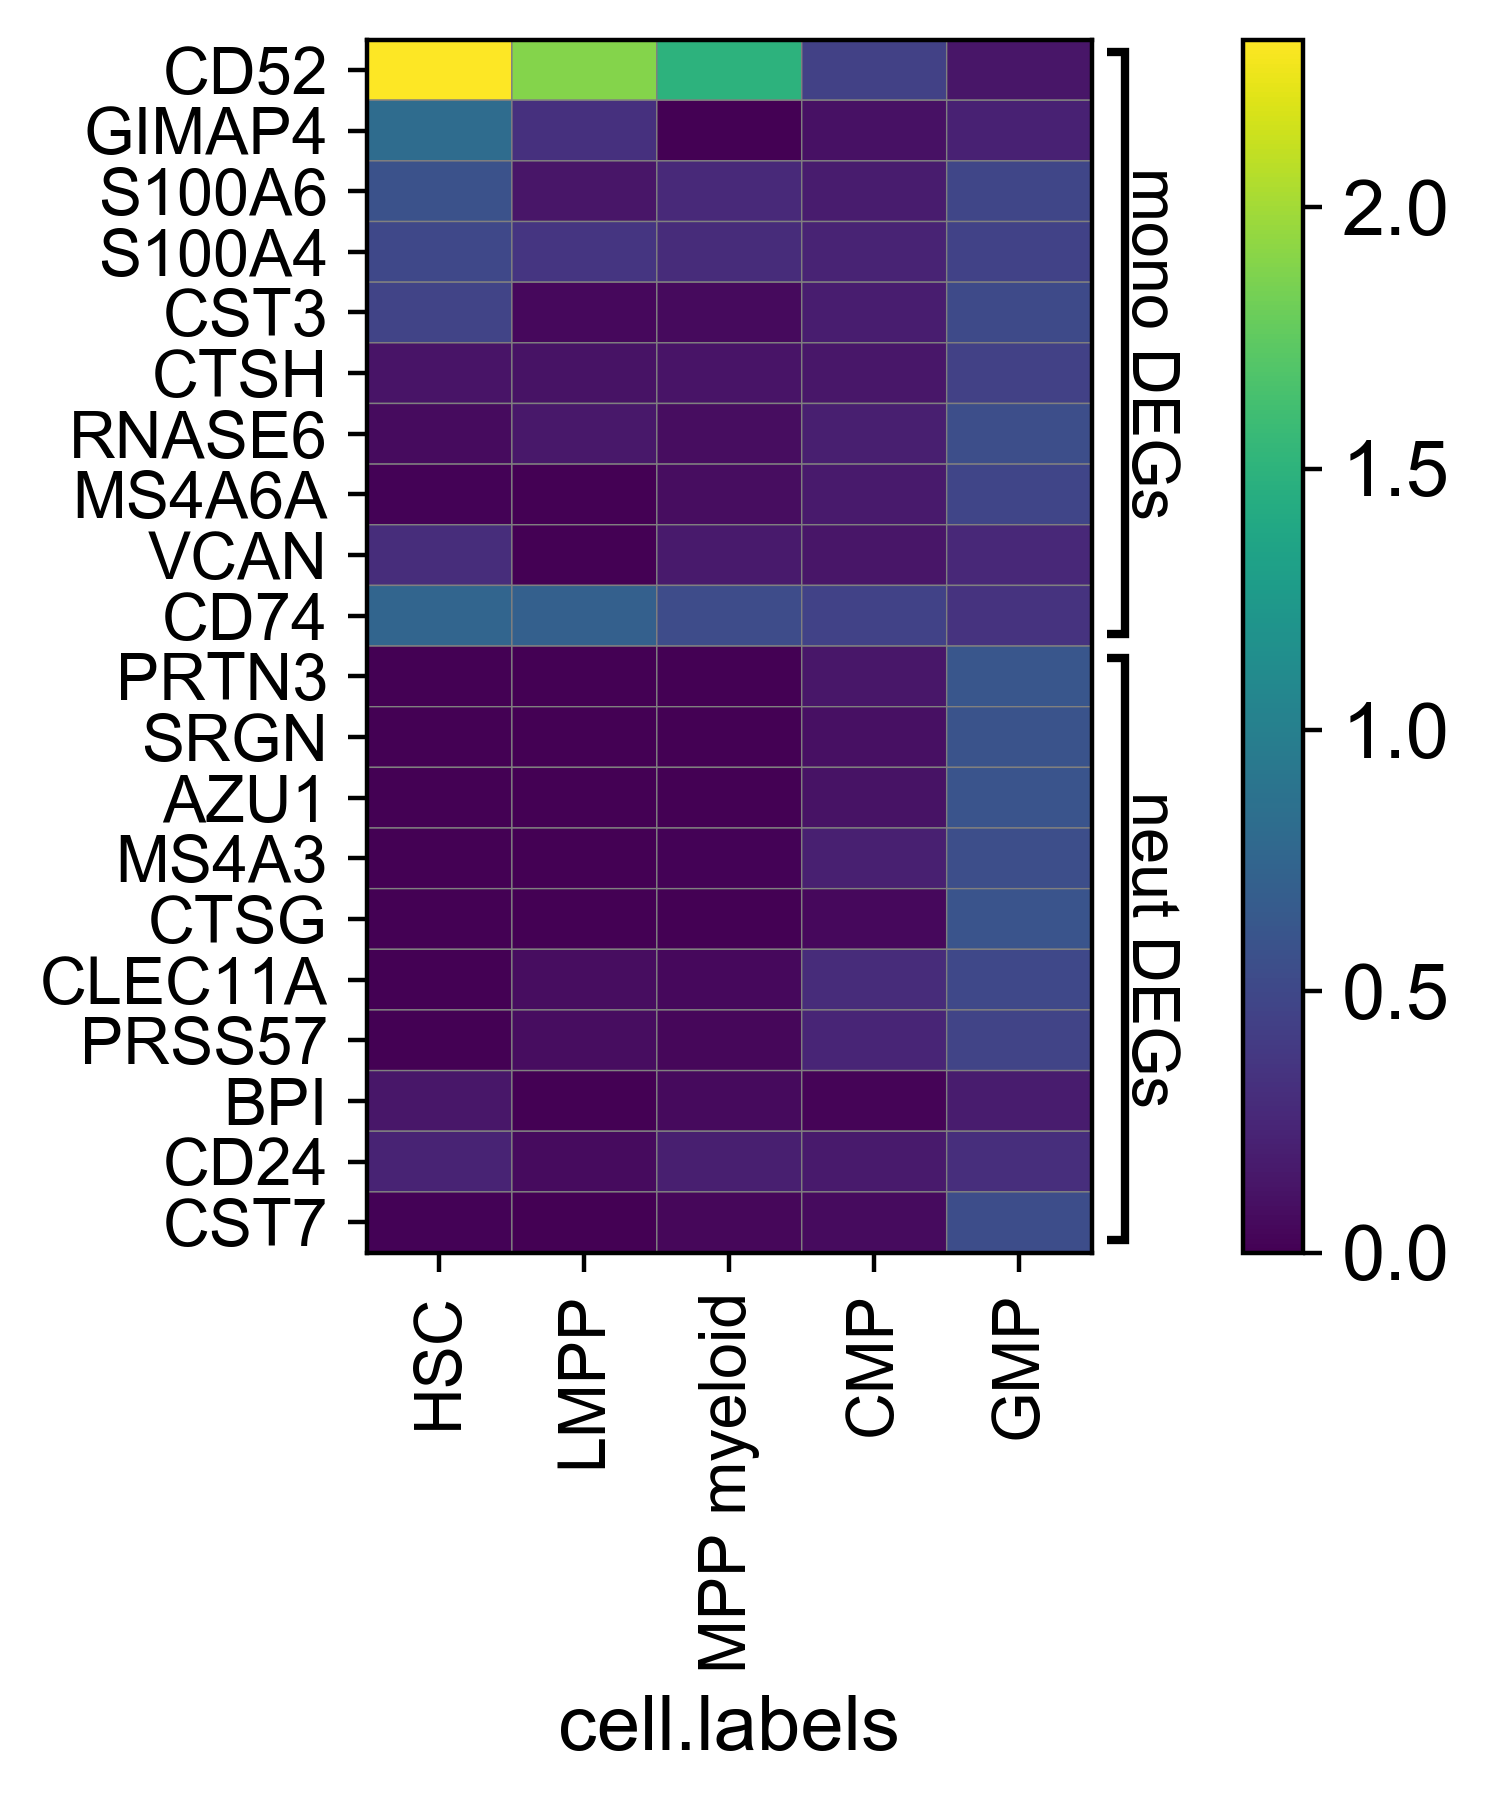

In [33]:
genes = ['CD52', # here are discrete premonocyte DEGs
'GIMAP4',
'S100A6',
'S100A4',
'CST3',
'CTSH',
'RNASE6',
'MS4A6A',
'VCAN',
'CD74',
# here are discrete promyelocyte DEGs
'PRTN3',
'SRGN',
'AZU1',
'MS4A3',
'CTSG',
'CLEC11A',
'PRSS57',
'BPI',
'CD24',
'CST7']

adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'MPP myeloid', 'CMP', 
                                             'GMP'])

gs = sc.pl.matrixplot(adata, var_names=genes, 
                      save="neut_myeloid_progen_heatmap_by_celltype_20200720.pdf",   
                      groupby='cell.labels', swap_axes=True, use_raw=False, figsize=[3,4], 
                      var_group_positions=[(0,9), (10, 19)], 
                      var_group_labels = ["mono DEGs", "neut DEGs"]) 

# Plot heatmaps of neut progen (per cell, showing neut/mono DEGs)

In [34]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC              92
LMPP             34
MPP myeloid      92
CMP             425
GMP            1285
dtype: int64

In [35]:
genes = ['CD52', # here are discrete premonocyte DEGs
'GIMAP4',
'S100A6',
'S100A4',
'CST3',
'CTSH',
'RNASE6',
'MS4A6A',
'VCAN',
'CD74',
# here are discrete promyelocyte DEGs
'PRTN3',
'SRGN',
'AZU1',
'MS4A3',
'CTSG',
'CLEC11A',
'PRSS57',
'BPI',
'CD24',
'CST7']

# subset the larger populations out

#adata_1 = adata[adata.obs['cell.labels'].isin(["HSC", "LMPP", "MPP myeloid", "CMP"])].copy()
#adata_2 = anndata.AnnData
#for i in ['GMP']: #adata.obs["cell.labels"].unique().tolist():
#    print(i)
#    subset = adata[adata.obs["cell.labels"].isin([i])].copy()
#    print(subset.shape)
#    sc.pp.subsample(subset, n_obs = 1000)
#    adata_2 = adata_2.concatenate(subset, join='outer', index_unique=None)
#tot_adata = adata_1.concatenate(adata_2, join='outer', index_unique=None)
    
#adata = tot_adata

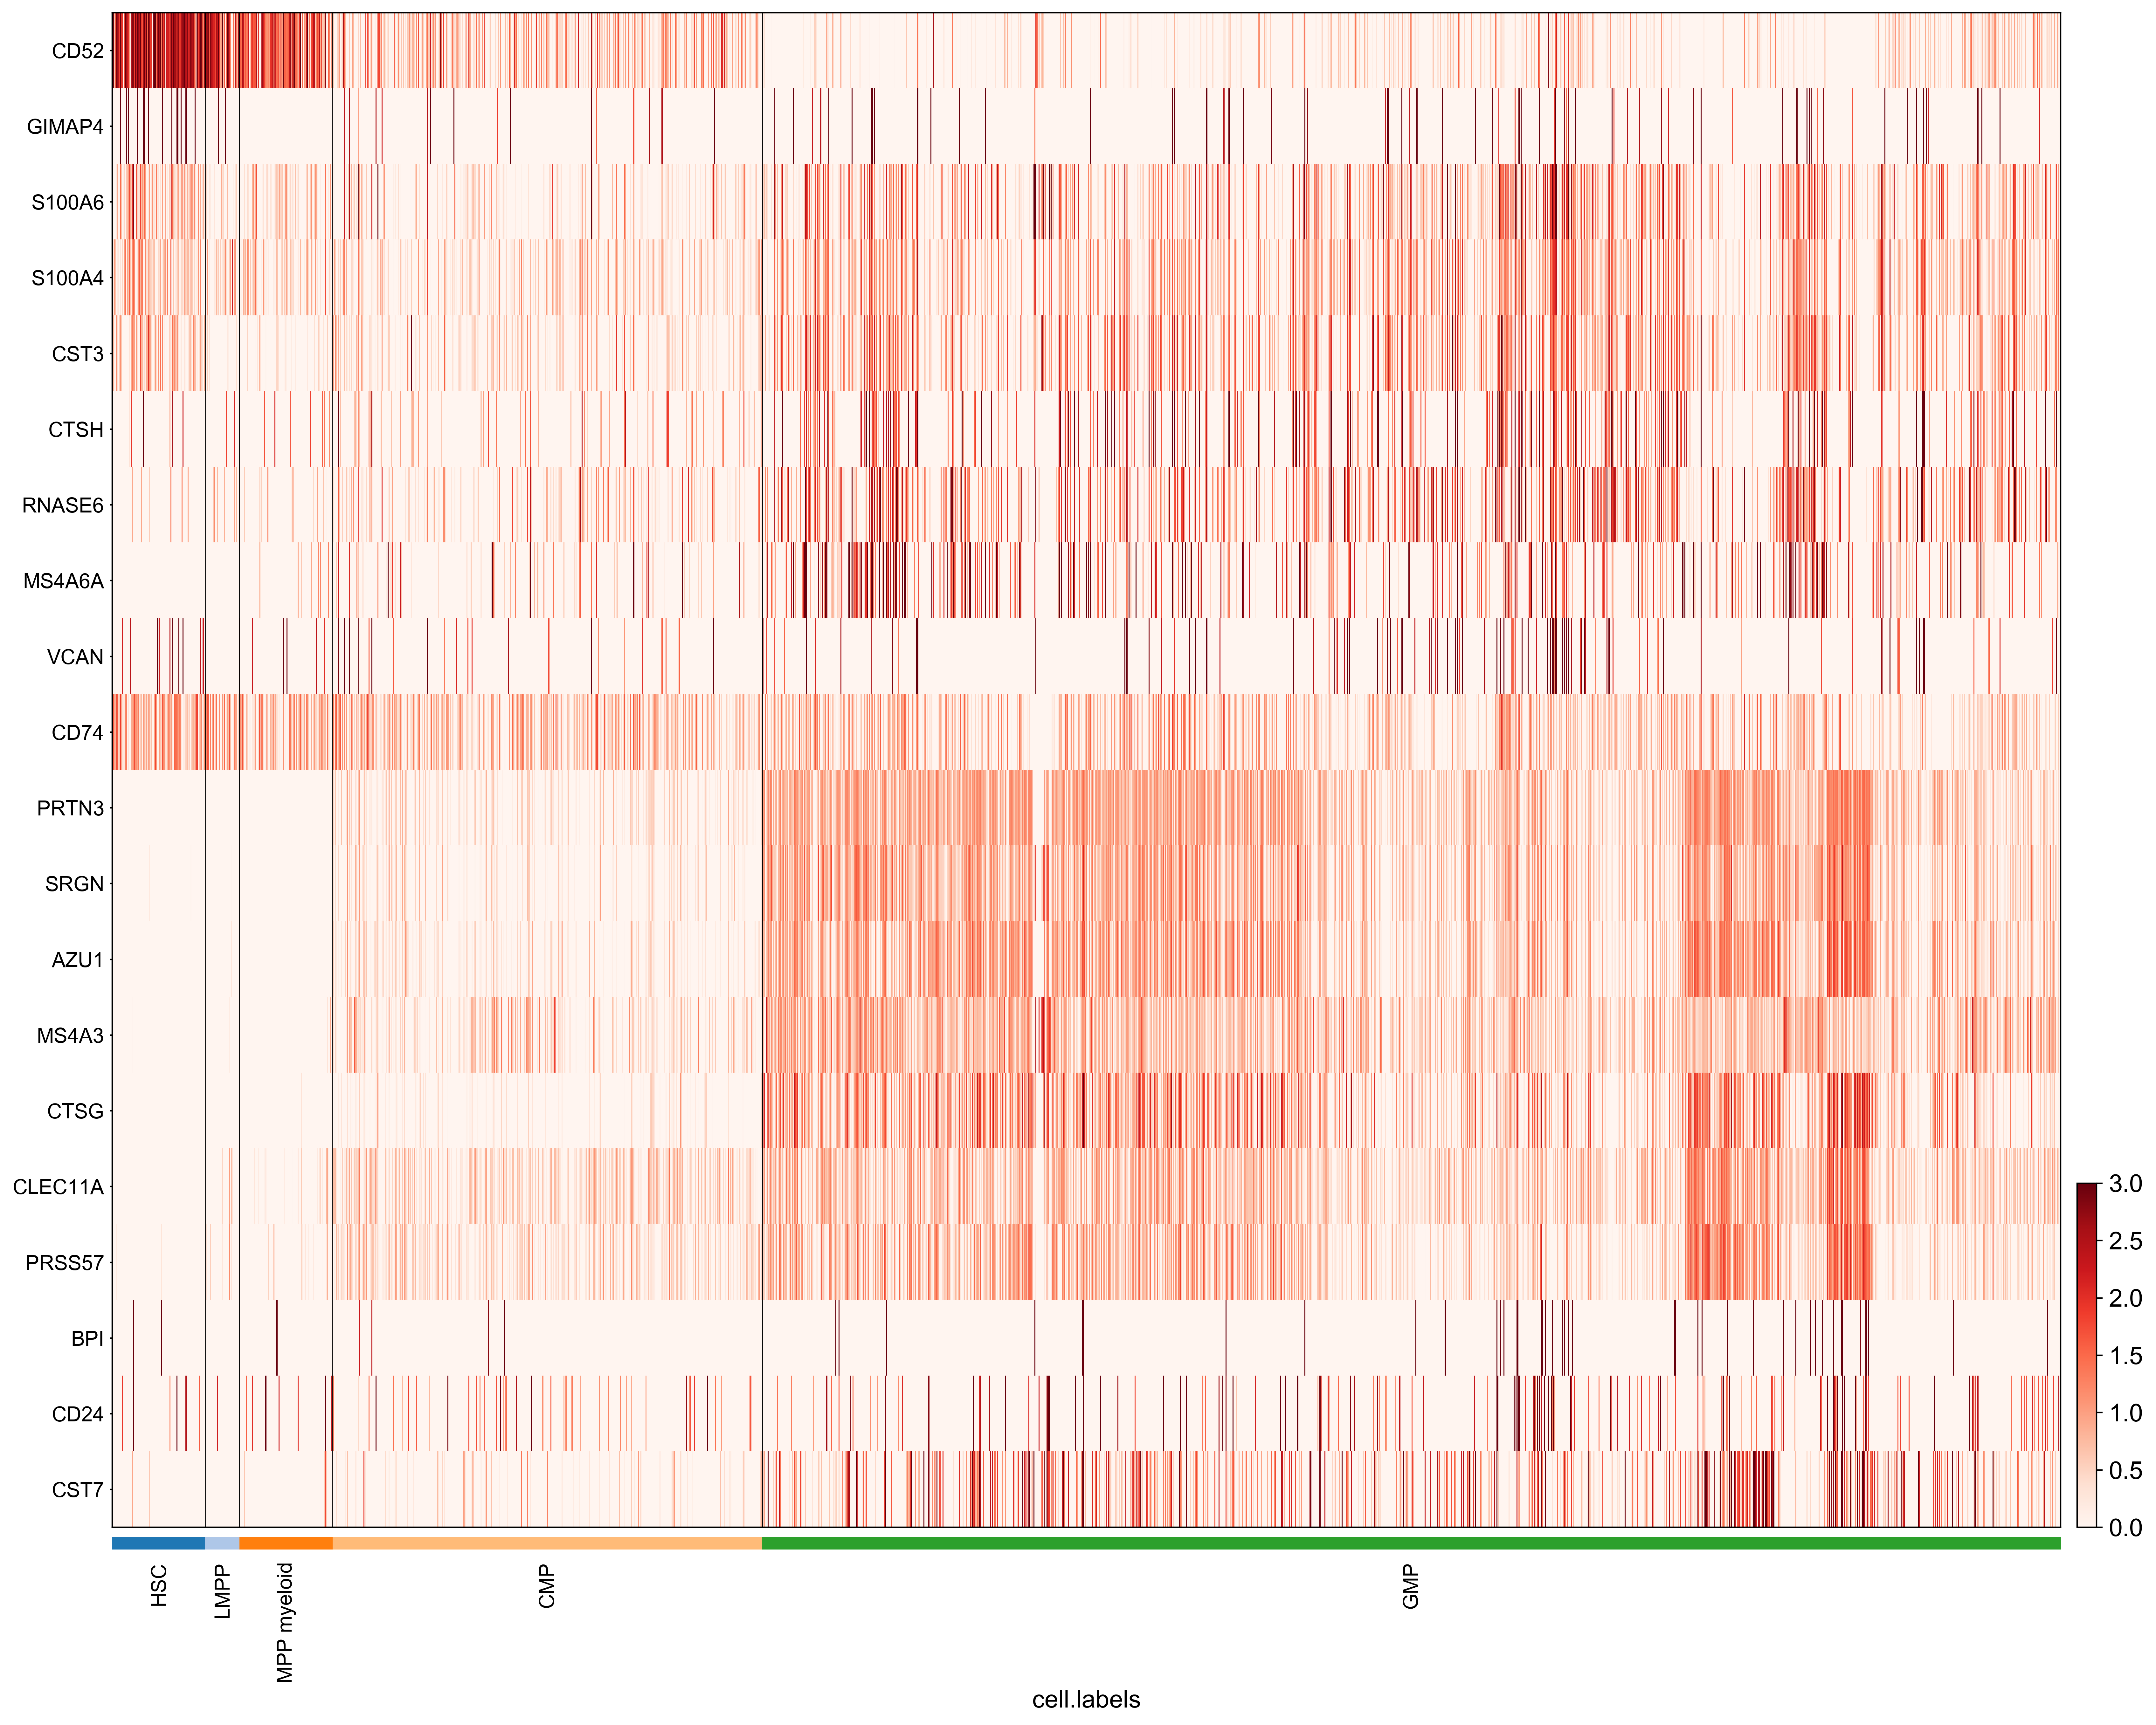

In [36]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'MPP myeloid', 
                                             'CMP', 'GMP'])

gs = sc.pl.heatmap(adata, var_names=genes, save="neut_myeloid_progen_heatmap_overall_20200720.pdf",   
                      groupby='cell.labels', swap_axes=True, use_raw=False, figsize=[20,16], 
                      cmap ='Reds', vmax=3)

In [37]:
adata.obs["index"] = adata.obs.index
adata.obs["index"] = pd.Categorical(adata.obs["index"])

In [38]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC              92
LMPP             34
MPP myeloid      92
CMP             425
GMP            1285
dtype: int64

In [39]:
subset = adata[adata.obs["cell.labels"].isin(["HSC"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_HSC_20200720.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.94,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [40]:
subset = adata[adata.obs["cell.labels"].isin(["LMPP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_LMPP_20200720.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.34,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [41]:
subset = adata[adata.obs["cell.labels"].isin(["MPP myeloid"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_MPP_myeloid_20200720.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[0.94,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [42]:
subset = adata[adata.obs["cell.labels"].isin(["CMP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_CMP_20200720.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[4.4,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

In [43]:
subset = adata[adata.obs["cell.labels"].isin(["GMP"])].copy()
sc.tl.dendrogram(subset, groupby='index')

gs = sc.pl.heatmap(subset, var_names=genes, save="neut_myeloid_progen_heatmap_GMP_20200720.pdf",   
                      groupby='index', swap_axes=True, use_raw=False, figsize=[13.2,12], 
                      cmap ='Reds', vmax=3, dendrogram=True, show=False)

# Save the data

In [44]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [45]:
adata.X

<1928x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 6429884 stored elements in Compressed Sparse Row format>

In [46]:
adata.raw.X

<1928x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 7485925 stored elements in Compressed Sparse Row format>

In [47]:
del adata.obs["index"]

In [48]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs2d_neut_myeloid_progen_heatmap_20200720.h5ad")